In [ ]:
%%capture
%pip install optuna catboost shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import sklearn
from sklearn.metrics import mean_absolute_percentage_error as mape, r2_score
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import os
import torch.nn as nn
import torch.optim as optim
import pickle
from tqdm import tqdm
from datetime import datetime
import shap

In [ ]:
!gdown 15awNEJ-AO-EgaZSevnZdkPFDBYTMSRJF
!gdown 1xq3i4Zuf7mNRvXPvEZyJsm60ayIRsw8H

Downloading...
From: https://drive.google.com/uc?id=15awNEJ-AO-EgaZSevnZdkPFDBYTMSRJF
To: /content/test_sfo_processed.csv
100% 11.5k/11.5k [00:00<00:00, 38.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xq3i4Zuf7mNRvXPvEZyJsm60ayIRsw8H
To: /content/train_sfo_processed.csv
100% 224k/224k [00:00<00:00, 4.44MB/s]


In [ ]:
train = pd.read_csv("/content/train_sfo_processed.csv")
test = pd.read_csv("/content/test_sfo_processed.csv")

# Tuning SARIMAX, best r^2: 0.061, mape: 0.061

In [ ]:
train["week"] = range(1, 245)

In [ ]:
train_arimo = train[["revenue"]]

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

X = train_arimo.values
train, test = X[:215], X[215:]

In [ ]:
import itertools
d = range(0, 3)
p = q = range(3, 13)
pdq = list(itertools.product(p, d, q))
s = [8]
pdqs = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q, s))]

In [ ]:
import optuna
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

def objective_sarima(trial):
    order=trial.suggest_categorical('order',pdq)
    seasonal_order=trial.suggest_categorical('seasonal_order',pdqs)
    trend=trial.suggest_categorical('trend',['n','c','t','ct',None])
    print("parameters selected")
    try:
      model = SARIMAX(train,order=order, seasonal_order=seasonal_order,trend=trend,initialization='approximate_diffuse')
      mdl = model.fit(disp=0)
      print("model trained, starting forecasting...")
      predictions = mdl.forecast(len(test))
      print("forecating done!")
      predictions = np.array(predictions).reshape(-1, 1)
      # mape = mean_absolute_percentage_error(test, predictions)
      r2 = r2_score(test, predictions)
      # accuracy = (r2 + (1- mape)) / 2
      # print(mape, r2)
      return r2
    except:
      return -100
study=optuna.create_study(direction="maximize")
study.optimize(objective_sarima,n_trials=200, show_progress_bar=True)


In [ ]:
study.best_trial.params = {'order': (5, 0, 1), 'seasonal_order': (9, 0, 9, 8), 'trend': None}

In [ ]:
model=SARIMAX(train,  order= (5, 0, 1), seasonal_order=(9, 0, 9, 8), trend= None, initialization='approximate_diffuse')
mdl = model.fit(disp=0)
print("model trained, starting forecasting...")
predictions = mdl.forecast(58)
print("forecating done!")
predictions = np.array(predictions).reshape(-1, 1)

model trained, starting forecasting...
forecating done!


In [ ]:
common = np.append(train, predictions)

In [ ]:
len(common)

273

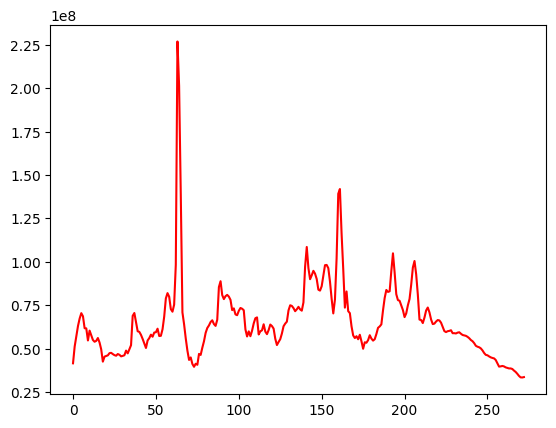

In [ ]:
plt.plot(test)
plt.plot(y_train.index.values, y_train)
plt.plot(common, color='red')
plt.show()

In [ ]:
pd.Series(predictions.reshape(1, 29)[0]).to_csv("predictions_sarimax_mape:0.065, r2:0.061.csv", index=False)

In [ ]:
raw_preds, target, preds = fcst.get_X_preds(X[splits[1]], y[splits[1]])

In [ ]:
mape = mean_absolute_percentage_error(target[0], preds[0])
r2 = r2_score(target[0], preds[0])

# Код для встраивания на сайт

In [ ]:
class TimeseriesDataset(torch.utils.data.Dataset):
      def __init__(self, X, y, window=52, num_preds=29):
          self.X = X
          self.y = y
          self.window = window
          self.num_preds = num_preds

      def __len__(self):
          return self.X.__len__() - self.window + 1

      def __getitem__(self, index):
          return (self.X[index:index+self.window], self.y[index+self.window:index+self.window+self.num_preds].reshape(-1))

def get_predicts(train, timestamp_column="timestamp", target_column="target", num_pred=29):

  def seed_everything(seed):    # Provide reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

  timestamps = train[timestamp_column].values


  num_cols = train.columns.values.tolist()
  num_cols.remove(timestamp_column)
  num_cols.remove(target_column)

  target_col = [target_column]
  train = train[num_cols+target_col]

  print(num_cols)
  ss = StandardScaler()
  train[num_cols] = ss.fit_transform(train[num_cols])

  ss_target = StandardScaler()
  train[[target_column]] = ss_target.fit_transform(train[[target_column]])


  X_train, y_train = train[num_cols+target_col], train[target_col]

  num_preds = num_pred



  data_length = train.shape[0]
  sliding_window = min(104, data_length//2)

  train_dataset = TimeseriesDataset(torch.tensor(X_train.values), torch.tensor(y_train.values), window=sliding_window, num_preds=num_preds)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle = False)

  num_features = X_train.shape[1]
  dataset_length = len(train_dataset)


  # MODEL

  class LstmTimeSeries(nn.Module):
      def __init__(
          self,
          hidden_size,
          num_layers,
          num_preds
      ):
          super(LstmTimeSeries, self).__init__()

          self.is_bidectional = False

          self.lstm = nn.LSTM(
              input_size=num_features,
              hidden_size=hidden_size,
              num_layers=num_layers,
              batch_first=True,
              bidirectional=self.is_bidectional
          )

          lstm_output_dim = hidden_size * (1 + self.is_bidectional)

          self.dropout1 = nn.Dropout(0.2)
          self.fc1 = nn.Linear(lstm_output_dim, lstm_output_dim//2)

          self.dropout2 = nn.Dropout(0.2)
          self.fc2 = nn.Linear(lstm_output_dim//2, lstm_output_dim//2)

          self.dropout3 = nn.Dropout(0.2)
          self.fc3 = nn.Linear(lstm_output_dim//2, num_preds)

          self.num_layers = num_layers
          self.hidden_size = hidden_size


      def forward(self, X, hidden=None, cell=None):

          out, (h_n, c_n) = self.lstm(X, (hidden, cell))
          out = torch.mean(out, dim=1)

          out = self.dropout1(out)
          out = self.fc1(out)
          out = self.dropout2(out)
          out = self.fc2(out)
          out = self.dropout3(out)
          out = self.fc3(out)

          return out, h_n, c_n

      def init_hidden(self, batch_size):
          h0 = torch.zeros(self.num_layers * (1 + self.is_bidectional), batch_size, self.hidden_size).to(device)
          c0 = torch.zeros(self.num_layers * (1 + self.is_bidectional), batch_size, self.hidden_size).to(device)
          return h0, c0



  # Training Setup
  hidden_size = 128
  num_layers = 1
  learning_rate = 3e-2
  epochs = 15
  batch_size = 1

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = LstmTimeSeries(
      hidden_size,
      num_layers,
      num_preds
  ).to(device)
  optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

  criterion = torch.nn.MSELoss(reduction='mean')

  # TRAINING


  seed_everything(42)

  for epoch in range(epochs):
      model.train()

      for count_batch, (X, y) in enumerate(tqdm(train_loader)):

          hidden, cell = model.init_hidden(batch_size=batch_size)

          if count_batch == dataset_length - 1: continue

          optimizer.zero_grad()

          pred, hidden, cell = model(X.float(), hidden, cell)

          loss = criterion(pred[:, :y.shape[1]], y.float())
          loss.backward()
          optimizer.step()


      model.eval()
      loss = 0
      pred, _, _ = model(X.float(), hidden, cell)

  pred = ss_target.inverse_transform(pred.detach().numpy()).reshape(-1)

  return model

In [ ]:
train = pd.read_csv("/content/train_sfo_processed_2.csv")

model = get_predicts(train, target_column="revenue")

<ipython-input-28-a9db05646a50>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[num_cols] = ss.fit_transform(train[num_cols])
<ipython-input-28-a9db05646a50>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[[target_column]] = ss_target.fit_transform(train[[target_column]])


['week_number', 'year', 'week', 'quantity', 'month', 'month_revenue', '150_r', '50_r', '500_r', '150_q', '50_q', '500_q', 'distribution', 'prescribes', 'disease_rate', 'price_index', 'generics_avg', 'generics_brands', 'total_video_rating', 'total_video_money', 'total_video_coverage_5', 'digital_money', 'radio_money', 'radio_times', 'wordstat', 'competitors_rating', 'competitors_coverage', 'competitors_money', 'competitors_digital', 'competitors_total', 'competitors_tv_reg']


100%|██████████| 141/141 [00:00<00:00, 179.42it/s]

tensor([[-0.1989, -0.0097,  0.2875,  0.3314,  0.6538,  0.7092,  0.6180,  0.5832,
          0.4196,  0.3693,  0.1202,  0.0431,  0.1972,  0.4595,  0.7131,  0.8423,
          0.8500,  0.7859,  0.6208,  0.3862,  0.3088,  0.3881,  0.1551,  0.1261,
          0.1014,  0.4264,  0.4665,  0.4039,  0.3092]],
       grad_fn=<AddmmBackward0>)


In [ ]:
def get_preds_koef(train, k, model, num_preds=29, target_column="revenue", timestamp_column="timestamp"):
  timestamps = train[timestamp_column].values

  num_cols = train.columns.values.tolist()
  num_cols.remove(timestamp_column)
  num_cols.remove(target_column)

  target_col = [target_column]
  train = train[num_cols+target_col]

  print(num_cols)
  ss = StandardScaler()
  train[num_cols] = ss.fit_transform(train[num_cols])

  ss_target = StandardScaler()
  train[[target_column]] = ss_target.fit_transform(train[[target_column]])


  X_train, y_train = train[num_cols+target_col], train[target_col]

  batch_size = 1
  sliding_window = 104

  X_train.loc[214, 'disease_rate'] *= k
  train_dataset = TimeseriesDataset(torch.tensor(X_train.values), torch.tensor(y_train.values), window=sliding_window, num_preds=num_preds)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle = False)
  hidden, cell = model.init_hidden(batch_size=batch_size)
  for count_batch, (X, y) in enumerate(tqdm(train_loader)):
      pass

  model.eval()
  pred, _, _ = model(X.float(), hidden, cell)

  pred = ss_target.inverse_transform(pred.detach().numpy()).reshape(-1)

  return pred

In [ ]:
pred = get_preds_koef(train, 1, model=model, target_column="revenue")

<ipython-input-31-c43c23a3a464>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[num_cols] = ss.fit_transform(train[num_cols])
<ipython-input-31-c43c23a3a464>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[[target_column]] = ss_target.fit_transform(train[[target_column]])


['week_number', 'year', 'week', 'quantity', 'month', 'month_revenue', '150_r', '50_r', '500_r', '150_q', '50_q', '500_q', 'distribution', 'prescribes', 'disease_rate', 'price_index', 'generics_avg', 'generics_brands', 'total_video_rating', 'total_video_money', 'total_video_coverage_5', 'digital_money', 'radio_money', 'radio_times', 'wordstat', 'competitors_rating', 'competitors_coverage', 'competitors_money', 'competitors_digital', 'competitors_total', 'competitors_tv_reg']


100%|██████████| 141/141 [00:00<00:00, 8530.42it/s]


In [ ]:
class EXCELWorker:
  def __init__(self, xlsx_path, timestamp_column=None, column_string=None, na_border=50, target_column="Продажи, рубли"):

    self.target_column = target_column
    self.timestamp_column = timestamp_column
    self.data = self.preprocess_init_data(xlsx_path, column_string, na_border)
    self.size = len(self.data)
    self.gbm_estimator = None
    self.train_part = None
    self.test_part = None
    self.test_dates = None

  def preprocess_init_data(self, xlsx_path, column_string, na_border):


    if column_string != None:
      df = pd.read_excel(xlsx_path, header=column_string)
    else:
      df = pd.read_excel(xlsx_path)

    df_nans_percent = df.isna().sum().values / len(df)
    na_border = df_nans_percent >= (na_border / 100)
    df = df.drop(columns=df.columns[na_border])

    return df

  def split(self,):

    self.test_part = self.data[self.data[self.target_column].isna()]
    self.train_part = self.data[~self.data[self.target_column].isna()]

    if self.timestamp_column != None:
      self.train_part[self.timestamp_column] = self.train_part[self.timestamp_column].apply(lambda x: x.timestamp())


  def contain_nan(self, df):
    nans = self.data.isna().sum()
    return nans[nans != 0].to_dict()

  #available na strtagies = "mean", "max", "median", "min", "value", "backwardfill", "forwardfill"
  def preprocess_excel(self, na_strategies):

    for column in list(na_strategies.keys()):

      na_strategy = na_strategies[column]
      fill_value = 0

      if type(na_strategy) == int:
        fill_value = na_strategy
      if na_strategy == "max":
        fill_value = self.data[column].max()
      if na_strategy == "min":
        fill_value = self.data[column].min()
      if na_strategy == "mean":
        fill_value = self.data[column].mean()
      if na_strategy == "median":
        fill_value = self.data[column].median()
      if na_strategy == "forwardfill":
        self.data[column] = self.data[column].fillna(method="ffill")
      if na_strategy == "backwardfill":
        self.data[column] = self.data[column].fillna(method="backfill")
      else:
        self.data[column] = self.data[column].fillna(fill_value)

  def train_model_and_get_predict(self, num_preds=29):
    preds = get_predicts(self.train_part, self.timestamp_column, self.target_column, num_preds)
    return preds

  def init_gbm(self, verbose=0):
    X = self.train_part.drop(columns=[self.target_column])
    y = self.train_part.loc[:, self.target_column]
    gbm = CatBoostRegressor(iterations=200)
    gbm.fit(X, y, verbose=verbose)
    self.gbm_estimator = gbm

  def get_change_by_param(self, changes):

    if self.gbm_estimator != None:

      target_object = self.train_part.iloc[len(self.train_part) - 1, :]
      X = target_object.drop(columns=[self.target_column])
      y = target_object.loc[self.target_column]

      for column in list(changes.keys()):

        X[column] += X[column]

      result = self.gbm_estimator.predict([X])
      return (((result - y) / y) * 100)

    else:
      raise Exception("no fitted model")

  def get_feature_importances(self):

    X = self.train_part.drop(columns=[self.target_column])
    y = self.train_part.loc[:, self.target_column]
    explainer = shap.TreeExplainer(self.gbm_estimator)
    shap_values = explainer(X, y)

    values = sorted(self.gbm_estimator.feature_importances_, reverse=True)
    features_ids = sorted(range(len(X.columns)), reverse=True, key = lambda x: self.gbm_estimator.feature_importances_[x])
    return shap_values, (values, features_ids)


In [ ]:
worker = EXCELWorker("/content/train.xlsx", timestamp_column="Начало нед", target_column="Продажи, рубли", column_string=5, na_border=100)
worker.split()
worker.train_part.fillna(0, inplace=True)
worker.train_part[worker.train_part.select_dtypes('object').columns] = worker.train_part.loc[:, worker.train_part.select_dtypes('object').columns].replace(' ', 0).astype('float')
worker.init_gbm(verbose=0)
preds = worker.train_model_and_get_predict(num_preds=29)
timestamps = worker.test_part["Начало нед"]

<ipython-input-184-e07b67eb9519>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_part[self.timestamp_column] = self.train_part[self.timestamp_column].apply(lambda x: x.timestamp())
<ipython-input-190-052038c36554>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worker.train_part.fillna(0, inplace=True)
<ipython-input-190-052038c36554>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

['год', 'неделя', 'Продажи, упаковки', 'Продажи, рубли.1', 'раствор 0.01 % 150 мл N1, руб', 'раствор  0.01 % 50 мл N1, руб', 'раствор 0.01 % 500 мл N1, руб', 'раствор 0.01 % 150 мл N1, упаковки', 'раствор  0.01 % 50 мл N1, упаковки', 'раствор 0.01 % 500 мл N1, упаковки', 'Дистрибуция Мирамистин', 'Выписки ', 'Статистика заболеваемости', 'Индекс цены', 'Развитие Дженериков \n(средняя дистрибуция)', 'Развитие Дженериков \n(кол-во брендов)', '(1)\nТВ, trp\n(Ж 30-60 ВС)', '(1)\nТВ, рубли', '(1)\nТВ, охват 5+\n(Ж 30-60 ВС)', '(2)\nТВ, trp\n(Ж 30-60 ВС)', '(2)\nТВ, рубли', '(2)\nТВ, охват 5+\n(Ж 30-60 ВС)', '(3)\nТВ, trp\n(Ж 30-60 ВС)', '(3)\nТВ, рубли', '(3)\nТВ, охват 5+\n(Ж 30-60 ВС)', '(4)\nТВ, trp\n(Ж 30-60 ВС)', '(4)\nТВ, рубли', '(4)\nТВ, охват 5+\n(Ж 30-60 ВС)', '(тотал)\nТВ, trp\n(Ж 30-60 ВС)', '(тотал)\nТВ, рубли', '(тотал)\nТВ, охват 5+\n(Ж 30-60 ВС)', 'Диджитал, рубли', 'Радио, рубли', 'Радио, количество выходов ', 'Запросы Wordstat', 'ТВ, trp\n(Ж 30-60 ВС)', 'ТВ, охват 5+\n(Ж 30

 62%|██████▏   | 88/141 [00:01<00:00, 72.15it/s]


KeyboardInterrupt: 

In [ ]:
timestamps = worker.test_part["Начало нед"]

In [ ]:
shap_values, feature_importance = worker.get_feature_importances()

<BarContainer object of 146 artists>

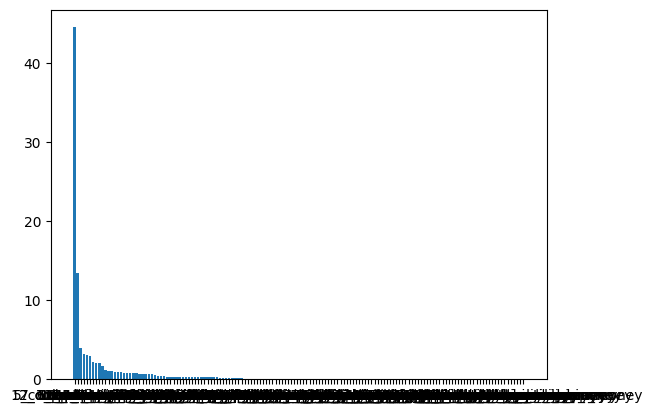

In [ ]:
plt.bar(worker.train_part.drop(columns=["revenue"]).columns[feature_importance[1][:5]], feature_importance[0][:5])

In [ ]:
shap.initjs()
shap.plots.force(shap_values[:])